<a href="https://colab.research.google.com/github/PSXBRosa/PG-article/blob/master/PolicyGradRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Notebook sobre _Policy Gradient_

## Introdução teórica

-----------------------
Lista de variáveis:

* $\tau$ é a trejetória. Por exemplo, se partindo do estado $S_1$ e tomando a ação $a_1$ chegamos no estado $S_2$, a trejatória $\tau$ desse exemplo será $\tau = (S_1, a_1, S_2)$

* $\theta$ é o conjunto de pesos da nossa ferramenta para aproximar a função, queremos optimizar esse conjunto de pesos com fins de maximizar a esperança dos retornos.

* $\pi$ é a nossa política, quando aparecer algo como $\pi(a = a_1 | S = S_1, \theta)$, isso deve ser interpretado como "a probabilidade do agente tomar a ação $a_1$, sendo que a função possui um conjunto de pesos $\theta$ e o agente se encontra no estado $S_1$".

* $E(X)$ é a esperança da variável aleatória $X$

* $R(\tau)$ é o retorno acumulado dada uma carta trejatória $\tau$. 

Para o desenvolvimento teórico que será feito, serão exigidos devidos conhecimentos da teoria de probabilidades e de otimizações.

-----------------------------------------------------------------

O algoritmo de _policy gradient_ decorre de uma única vontade: otimizar um conjunto randômico de pesos para conseguir maximizar a função $ J(\pi_\theta) = E[R(\tau)]$. Utilizando o método de _gradient ascent_ é simples atingir esse objetivo, uma vez conhecido o gradiente de tal função. Os desenvolvimentos a seguir serão feitos justamente para obter o gradiente dessa esperança em termos possíveis de serem computados.

Expandindo a esperança:

$
\begin{align}
E[R(\tau)] &= \int_\tau P(\tau | \theta) R(\tau)\\
&= \int_\tau \rho(s_0)\prod_{t=0}^T P(S_{t+1} | S_t, a_t)\pi(a_t|s_t,\theta)R(\tau)
\end{align}
$

a expressão inferior é simples decorrencia da lei do produto para combinações.

Tiraremos agora o gradiente de $E[R(\tau)]$, $\nabla E[R(\tau)]$ em relação a $\theta$.

OBS:
$$\frac{\partial log(x(t))}{\partial t} = \frac{1}{x(t)}\frac{\partial x(t)}{\partial t}$$

ou seja

$$\nabla x(t) = \nabla log(x(t))x(t)$$

$
\begin{align}
\nabla E[R(\tau)] &= \int_\tau \nabla\rho(s_0)\prod_{t=0}^T P(S_{t+1} | S_t, a_t)\pi(a_t|s_t,\theta)R(\tau)\\
&= \int_\tau \nabla\{log(p(s_0)) + \sum_{t=0}^{T} [log(P(S_{t+1} |S_t, a_t) + log(\pi(a_t| s_t, \theta)]\}R(\tau)P(\tau|\theta)\\
&= \int_\tau \sum_{t=0}^T\nabla log(\pi(a_t | s_t, \theta))R(\tau)P(\tau | \theta)
\end{align}
$

essa última passagem é válida, pois os termos anulados não possuem dependência em $\theta$

terminamos ao voltar essa última expressão para forma de esperança

$
\begin{align}
\nabla E[R(\tau)] &= \int_\tau \sum_{t=0}^T\nabla log(\pi(a_t | s_t, \theta))R(\tau)P(\tau | \theta)\\
&= E\Big[\sum_{t=0}^T\nabla log(\pi(a_t | s_t, \theta))R(\tau)\Big]
\end{align}
$

uma aproximação pela média aritimética é possível dado um grande número (N) de trajetórias experienciadas. Procure por _Markov Chain Monte-Carlo (MCMC)_

![](https://i.imgur.com/5f0ZxoN.png)
[fonte](http://www.est.ufmg.br/~cristianocs/MetComput/Aula2.pdf)

Chegamos então no final dessa expansão teórica:

$$\nabla J(\pi_\theta) = E\Big[\sum_{t=0}^T\nabla log(\pi(a_t | s_t, \theta))R(\tau)\Big]$$
$$\boxed{ĝ = \frac{1}{N}\sum_N\sum_{t=0}^T\nabla log(\pi(a_t | s_t, \theta))R(\tau)}$$

---------------------------------


![](https://spinningup.openai.com/en/latest/_images/math/262538f3077a7be8ce89066abbab523575132996.svg)

![](https://i.imgur.com/Gwrwst6.png)

![](blob:https://imgur.com/c7bb70df-443a-46a5-b398-f1aaed5fcb3e)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import gym
from statistics import stdev
import numpy as np

class PgAgent:
    def __init__(self,
                obs_dim,
                action_space,
                gamma=0.9,
                alpha=0.005,
                padronize = False,
                mode = "mean",
                load = False,
                file_path = "dqnsavep.pth"):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._gamma     = gamma
        self._padronize = padronize
        self._alpha     = alpha
        self._obs_dim   = obs_dim
        self._as        = action_space
        self._mode      = mode

        self._network = nn.Sequential(nn.Linear(obs_dim,16),
                                      nn.ReLU(),
                                      nn.Linear(16,16),
                                      nn.ReLU(),
                                      nn.Linear(16,action_space),
                                      nn.Softmax(dim=1)).to(self.device)

        # criamos o otimizador
        self._optmin  = optim.Adam(self._network.parameters(),
                                   self._alpha)
        self.reset_memory()

    # criamos a memória, alguns elementos não serão utilizados
    def reset_memory(self):
        self._memory ={"states"  : torch.zeros((500,self._obs_dim)).to(self.device),
                       "actions" : torch.zeros(500).to(self.device),
                       "rewards" : torch.zeros(500).double().to(self.device),
                       "sstates" : torch.zeros((500,self._obs_dim)).to(self.device),
                       "dones"   : torch.zeros(500).to(self.device)}

    # para adicionar um elemento à memória, utilizaremos esse método especial
    def __setitem__(self, index, exp):
        s,a,r,ss,d = exp
        self._memory["states" ][index] = torch.tensor(s)
        self._memory["actions"][index] = torch.tensor(a)
        self._memory["rewards"][index] = torch.tensor(r)
        self._memory["sstates"][index] = torch.tensor(ss)
        self._memory["dones"  ][index] = torch.tensor(d)
    
    # para calcularmos a ação a partir de um estado, utilizaremos outro método
    # especial.
    def __call__(self, x):
        x = torch.tensor(x).float().to(self.device)
        probs = self._network(x.unsqueeze(0))
        probs = Categorical(probs = probs)
        actions = probs.sample().item()
        return actions

    # método privado para cálcular a perdão
    def _loss(self, probs, actions, rewards):

        # utilizaremos a classe do pytorch para distribuições de probabilidade
        # é interessante utilizar essa classe pois ela permite algumas opera -
        # ções relacionadas à probabilidade de forma mais simples.
        probs     = Categorical(probs) 
        log_probs = probs.log_prob(actions)
        cum_sum   = self._cummulativesum(rewards)
        if self._mode == "sum": policy_loss = -(log_probs*cum_sum).sum()
        elif self._mode == "mean": policy_loss = -(log_probs*cum_sum).mean()
        return policy_loss

    # método privado para calcular a soma acumulada
    def _cummulativesum(self, rewards):
        n        = len(rewards)
        discout  = self._gamma ** torch.arange(1,n+1, dtype = torch.float64)
        returns  = torch.flip(rewards, [0]) * discout.to(self.device)
        returns  = torch.cumsum(returns, dim=0)
        returns  = torch.flip(returns, [0])
        # transformaremos a distribuição dos retornos para a normal padroniza -
        # da, uma vez que redes neurais lidam melhor com esse tipo de distri -
        # buição de dados
        if self._padronize:
            mean     = returns.mean()
            stdev    = torch.std(returns)
            returns  =  (returns - mean)/stdev
        return returns

    def train(self, steps):
        states  = self._memory["states"][:steps]
        actions = self._memory["actions"][:steps]
        rewards = self._memory["rewards"][:steps]
        probs  = self._network(states.reshape(-1,self._obs_dim))
        
        loss = self._loss(probs, actions, rewards)
        self._optmin.zero_grad()
        loss.backward()
        self._optmin.step()
        return loss



In [ ]:
def compute(rewards):
    means = []
    devp = []
    interval = 5
    for index in range(len(rewards)):
        start = max(0, index - interval)
        end   = min(len(rewards)-1, index + interval)
        part  = rewards[start:end+1]
        ssum  = sum(part)
        devp.append(stdev(part))
        means.append(ssum/(end - start + 1))

    means = np.array(means)
    devp  = np.array(devp)

    return means, devp

def main(episodes, alpha, gamma, padronize, type, printing = False):
    env   = gym.make("CartPole-v0")
    #torch.random.manual_seed(1)
    #env.seed(1)
    agent = PgAgent(4,2, alpha = alpha, gamma = gamma, padronize = padronize, mode = type)
    N_episodes = episodes
    rewards    = [0]*N_episodes
    for i in range(1,N_episodes+1):
        
        steps     = 0
        ep_loss   = 0
        ep_reward = 0
        d         = False
        s         = env.reset()

        while not d:
            action = agent(s)
            s2, r, d, _ = env.step(action)
            agent[steps] = (s, action, r, s2, d)

            s = s2
            ep_reward += r
            steps     += 1
    
        rewards[i-1]  = ep_reward
        for j in range(2):
            loss = agent.train(steps)
            if loss is not None and loss > -float("inf"):
                ep_loss   += loss
        agent.reset_memory()
        if printing:
            print(f"\r(ep : {i:03d} | rewards : {int(ep_reward):03d} | loss : {ep_loss:.2f} |)",end="",flush=True)
    return rewards

(ep : 500 | rewards : 092 | loss : -0.15 |)

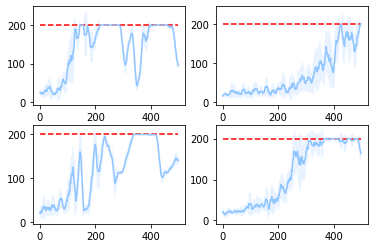

In [ ]:
r1 = main(500, 0.003, 0.99,   True, "mean", printing = True)
r2 = main(500, 0.001, 0.99,   True, "mean")
r3 = main(500, 0.003, 0.99,   False, "sum")
r4 = main(500, 0.001, 0.99,   False, "sum")

with plt.style.context("seaborn-pastel"):
    c = 0
    for i in [r1,r2,r3,r4]:
        c += 1
        plt.subplot(2,2,c)
        means, std = compute(i)
        low  = means - std
        high = means + std
        x = [k for k in range(len(i))]
        plt.plot(x, [200 for n in x], "--", color = "red")
        plt.fill_between(x, low, high, alpha=0.2)
        plt.plot(x, means)
    plt.show()